## Installing Dependencies

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.Max_columns', None)
import re
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline
sns.set()
import warnings
import sys

warnings.filterwarnings("ignore")
warnings.warn("This warning will not be displayed")

warnings.showwarning("This warning will not be displayed", UserWarning, "example.py", 42, file=sys.stdout)




example.py:42: UserWarning: This warning will not be displayed


## Understanding the data

In [207]:
data = pd.read_csv(r'Data\Final_train_data.csv')
df= data.copy()

In [208]:
df.shape

(9172, 30)

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        9172 non-null   int64 
 1   sex                        9172 non-null   object
 2   on_thyroxine               9172 non-null   object
 3   query_on_thyroxine         9172 non-null   object
 4   on_antithyroid_medication  9172 non-null   object
 5   sick                       9172 non-null   object
 6   pregnant                   9172 non-null   object
 7   thyroid_surgery            9172 non-null   object
 8   I131_treatment             9172 non-null   object
 9   query_hypothyroid          9172 non-null   object
 10  query_hyperthyroid         9172 non-null   object
 11  lithium                    9172 non-null   object
 12  goitre                     9172 non-null   object
 13  tumor                      9172 non-null   object
 14  hypopitu

## Handeling Data Inconsistancy

In [210]:
# Checking for missing values
df.isnull().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
index,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The above dataframe shows, there are no missing value present in the dataset but the absent values has shown with "?" symbol.
* Let's first replace it with NaN and check the number of missing values in each attribute.

In [211]:
# Replacing "?" with nan values
df = df.replace('?',np.nan)
df.isnull().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
index,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,0,307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,842,0,2604,0,442,0,809,0,802,0,8823,0,0


In [212]:
df['TBG_measured'].value_counts()

f    8823
t     349
Name: TBG_measured, dtype: int64

* The variable TBG has almost all the values are NaN values, so it will not provide any meaningful information. It is better to drop the whole feature.
* Another thing to observe, The values of attributes like T3, TT4, etc are present where its measured attribute is showing True. We do not need two different attributes that provide similar information.

In [213]:
# dropping the columns that show similar information
columns_measured = ['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured', 'TBG_measured', 'TBG']
df.drop(columns_measured,axis=1,inplace= True)

In [214]:
df['Class'].head()

0    -[840801013]
1    -[840801014]
2    -[840801042]
3    -[840803046]
4    S[840803047]
Name: Class, dtype: object

* In the target variable there are in consistency in the classes. We will define the values that starts with "-" symbol as negative which means patient has tested negative for thyroid or healthy. The record starts with alphabates represent the thyroid condition patient may have.

In [215]:
for i in range(len(df['Class'].unique())):
    pattern = r'[A-Za-z]+'
    if str(df['Class'][i]).startswith('-'):
        df['Class'][i]= "Nagetive"
    else:
        x = re.findall(pattern,df['Class'][i])
        df['Class'][i] = ''.join(x)
df['Class'].unique()

array(['Nagetive', 'S', 'F', 'AK', 'R', 'I', 'M', 'N', 'G', 'K', 'A',
       'KJ', 'L', 'MK', 'Q', 'J', 'CI', 'O', 'LJ', 'HK', 'D', 'GK', 'MI',
       'P', 'FK', 'B', 'GI', 'C', 'GKJ', 'OI', 'DR', 'E'], dtype=object)

In [216]:
len(df['Class'].unique())

32

* As we can see there are total 32 different classes available.

## Handling Missing values

* Replacing missing values with the help of KNN imputer.

In [217]:
from sklearn.impute import KNNImputer
KnnIm=KNNImputer(n_neighbors=3,weights='uniform',missing_values=np.nan)
columns = ['TSH','T3', 'TT4','T4U','FTI']

for i in columns:
    df[i]=KnnIm.fit_transform(df[[i]])

In [218]:
df.isnull().sum()

age                            0
sex                          307
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                            0
T3                             0
TT4                            0
T4U                            0
FTI                            0
referral_source                0
Class                          0
dtype: int64

In [219]:
df['sex'].unique()

array(['F', 'M', nan], dtype=object)

* In the sex column we can impute the most frequent catagory in place of Nan values.

In [220]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
imputer.fit(df[['sex']])
df['sex']= imputer.transform(df[['sex']])

In [221]:
df.isnull().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
index,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [222]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,0.300000,1.970629,108.700305,0.976056,113.640746,other,Nagetive
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,1.600000,1.900000,128.000000,0.976056,113.640746,other,Nagetive
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,5.218403,1.970629,108.700305,0.976056,113.640746,other,Nagetive
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,5.218403,1.970629,108.700305,0.976056,113.640746,other,Nagetive
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,5.218403,1.970629,108.700305,0.976056,113.640746,other,S


<Axes: >

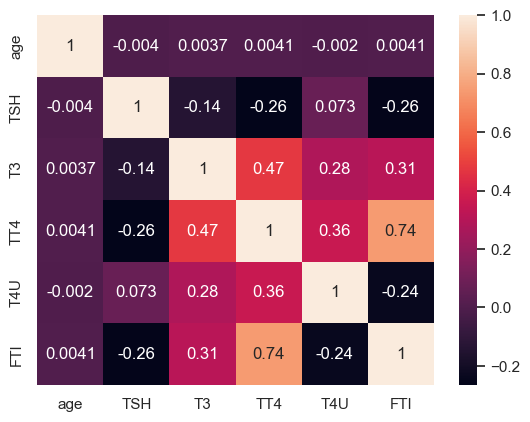

In [223]:
sns.heatmap(df.corr(),annot=True)

* From the above heatmap, it is clear that TT4 attribute is highly corelated with FTI column we can drop the column.

## Handling Categorical variable

In [224]:
df['sex'].unique()

array(['F', 'M'], dtype=object)

In [225]:
# Firstly, we encode the sex attribute as it has only two categories.
df['sex'] = df['sex'].map({'F' : 1,'M': 2})

In [226]:
df.sex.head()

0    1
1    1
2    1
3    1
4    1
Name: sex, dtype: int64

In [227]:
# Secondly, Variables with bool value also be encoded
for var in df.columns:
    if var !='sex' and len(df[var].unique()) == 2:
       df[var] = df[var].map({'f': 0, 't': 1})

In [228]:
# We can get dummies for refferal_sources as it has more than two categories and that also are not in order.
df = pd.get_dummies(df, columns=['referral_source'],prefix='ref')

In [229]:
df['Class'].unique()

array(['Nagetive', 'S', 'F', 'AK', 'R', 'I', 'M', 'N', 'G', 'K', 'A',
       'KJ', 'L', 'MK', 'Q', 'J', 'CI', 'O', 'LJ', 'HK', 'D', 'GK', 'MI',
       'P', 'FK', 'B', 'GI', 'C', 'GKJ', 'OI', 'DR', 'E'], dtype=object)

In [230]:
# Lastly, we label encode our target attribute "Class"
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])


In [231]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,ref_STMW,ref_SVHC,ref_SVHD,ref_SVI,ref_WEST,ref_other
0,29,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.300000,1.970629,108.700305,0.976056,113.640746,25,0,0,0,0,0,1
1,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.600000,1.900000,128.000000,0.976056,113.640746,25,0,0,0,0,0,1
2,41,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.218403,1.970629,108.700305,0.976056,113.640746,25,0,0,0,0,0,1
3,36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.218403,1.970629,108.700305,0.976056,113.640746,25,0,0,0,0,0,1
4,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.218403,1.970629,108.700305,0.976056,113.640746,31,0,0,0,0,0,1


* Now, after encoding all of our categorical attributes, let's deal with missing values present in the dataset.

In [232]:
df['Class'].unique()

array([25, 31,  8,  1, 30, 15, 21, 24, 10, 17,  0, 18, 19, 23, 29, 16,  4,
       26, 20, 14,  5, 12, 22, 28,  9,  2, 11,  3, 13, 27,  6,  7])

## Checking the distribution of the continuous Variables

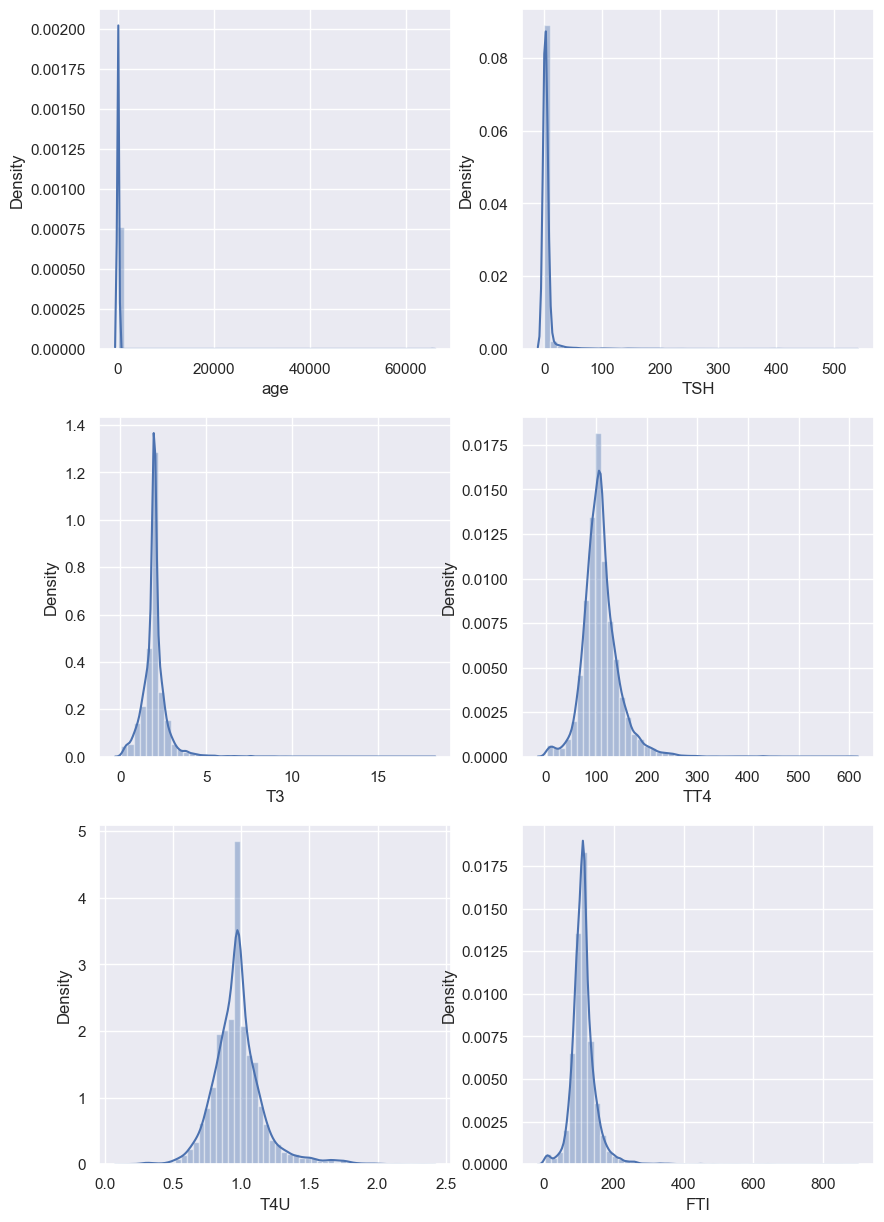

In [233]:
continuous_att = ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']
plt.figure(figsize = (10,15))
pltnum = 1
for cols in continuous_att:
    ax = plt.subplot(3,2,pltnum)
    sns.distplot(df[cols],kde=True)
    plt.xlabel(cols)
    pltnum += 1
plt.show()

* It is clear from the histogram above, The data distribution is skewed on the left. We can improve it by applying log to it.

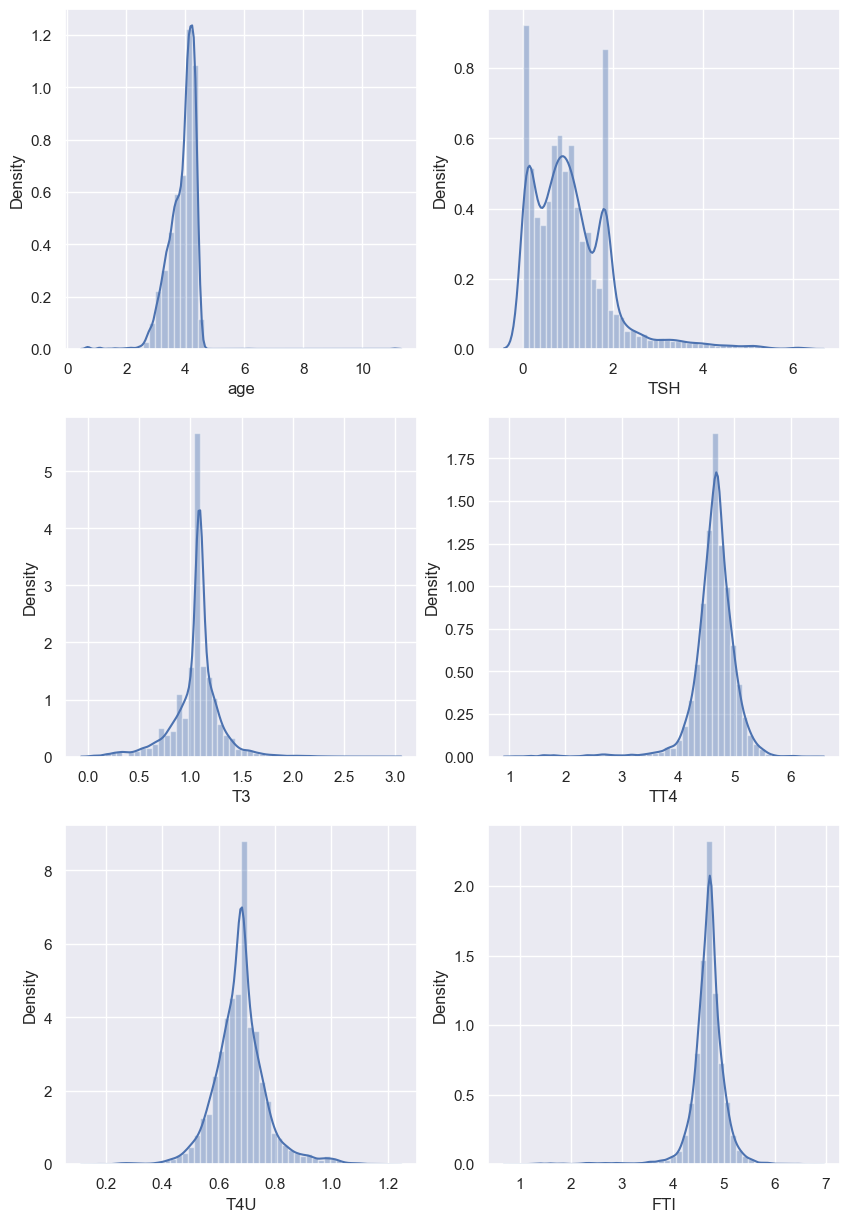

In [234]:
continuous_att = ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']
plt.figure(figsize = (10,15))
pltnum = 1
for cols in continuous_att:
    df[cols] += 1
    ax = plt.subplot(3,2,pltnum)
    sns.distplot(np.log(df[cols]))
    plt.xlabel(cols)
    pltnum += 1
plt.show()

* The attribute TSH has wierd trend. it is better to drop the attribute.

In [235]:
df = df.drop(['TSH'],axis = 1)

In [236]:
x = df.drop(['Class'],axis= 1)
y = df['Class']

In [237]:
x.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,ref_STMW,ref_SVHC,ref_SVHD,ref_SVI,ref_WEST,ref_other
0,30,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.970629,109.700305,1.976056,114.640746,0,0,0,0,0,1
1,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.900000,129.000000,1.976056,114.640746,0,0,0,0,0,1
2,42,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.970629,109.700305,1.976056,114.640746,0,0,0,0,0,1
3,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.970629,109.700305,1.976056,114.640746,0,0,0,0,0,1
4,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.970629,109.700305,1.976056,114.640746,0,0,0,0,0,1


In [238]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
scaler.fit(x)
scaled_data = scaler.transform(x)

In [239]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
x_pca = pca.fit_transform(scaled_data)

In [240]:
X = pd.DataFrame(data = x_pca,columns=['component_1','component_2','component_3','component_4','component_5','component_6','component_7','component_8','component_9','component_10'])

In [241]:
X.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,0.641145,-1.180104,-0.121670,-0.537054,0.464595,1.316176,-0.983128,0.846736,0.201773,0.019250
1,0.704781,-0.528051,-0.247526,-0.180256,-0.069371,-0.117800,0.056128,-0.387592,-0.138245,-0.040956
2,1.151632,-0.756096,-0.119378,-0.402954,-0.416973,-1.857902,-0.687600,0.849144,-0.091342,0.045558
3,0.503960,-0.647842,-0.182322,-0.350906,-0.082100,-0.191047,0.055423,-0.379041,-0.108581,-0.027920
4,0.503942,-0.647809,-0.182272,-0.350920,-0.082014,-0.190830,0.055451,-0.378990,-0.108839,-0.030982


array([[<Axes: title={'center': 'component_1'}>,
        <Axes: title={'center': 'component_2'}>,
        <Axes: title={'center': 'component_3'}>],
       [<Axes: title={'center': 'component_4'}>,
        <Axes: title={'center': 'component_5'}>,
        <Axes: title={'center': 'component_6'}>],
       [<Axes: title={'center': 'component_7'}>,
        <Axes: title={'center': 'component_8'}>,
        <Axes: title={'center': 'component_9'}>],
       [<Axes: title={'center': 'component_10'}>, <Axes: >, <Axes: >]],
      dtype=object)

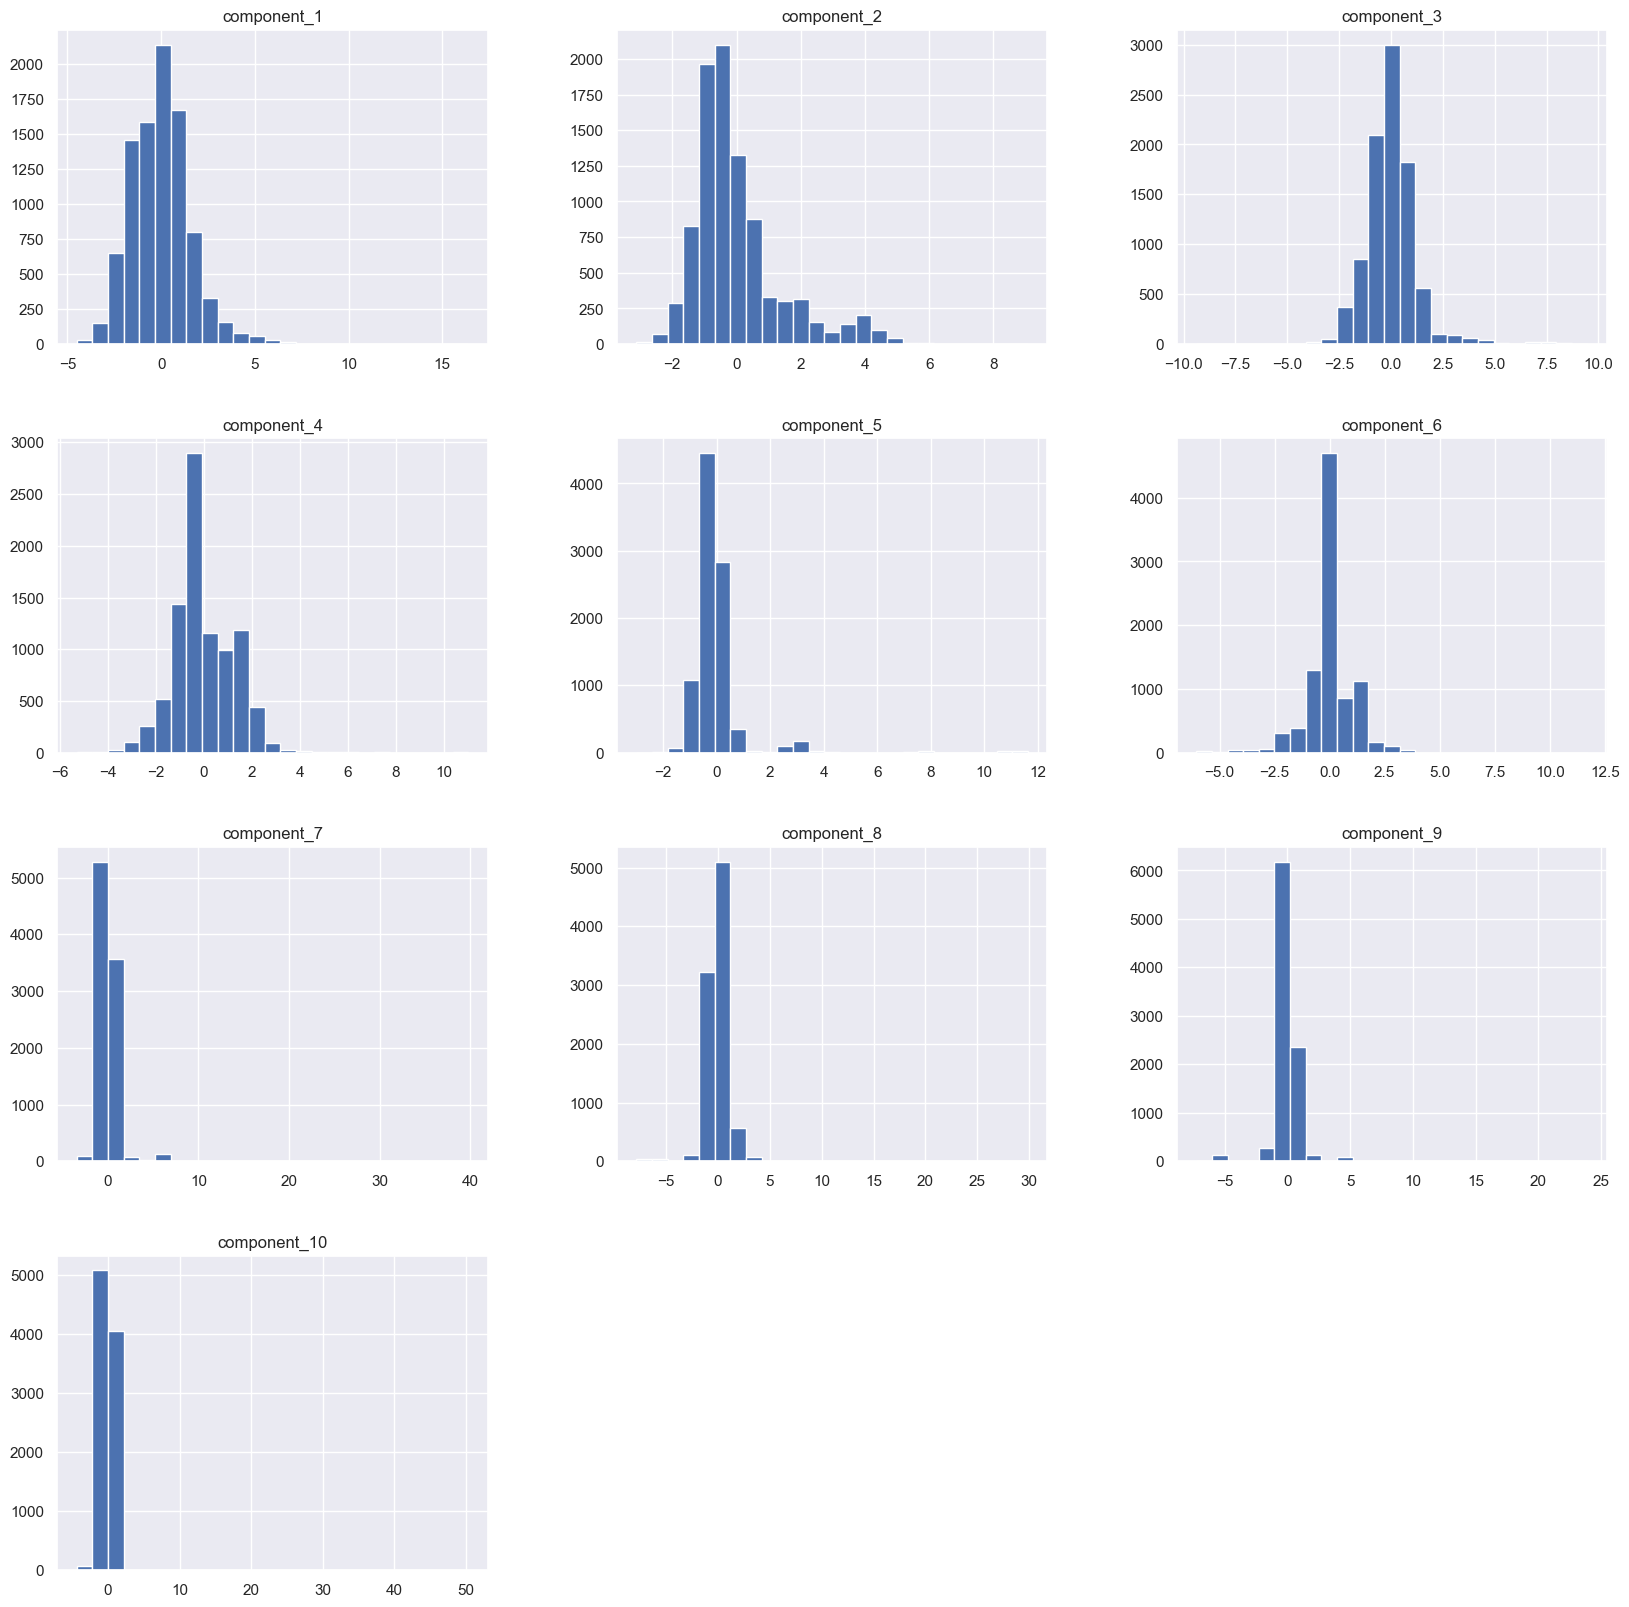

In [242]:
X.hist(bins=25,figsize=(20,20))

In [243]:
pca.explained_variance_

array([2.60205633, 1.98448629, 1.70094161, 1.59305265, 1.24891063,
       1.17854938, 1.14448206, 1.04468788, 1.01578209, 1.00291456])

In [244]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state= 42)

In [245]:
def prediction(model):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        print(f'|| Model name: {model}')
        model = model.fit(x_train,y_train)
        score = model.score(x_train, y_train)
        print(f"|| Model score: {float(format(score,'.3f'))}                                            ||")
        test_score= model.score(x_test, y_test)
        print(f"|| Model Test_score: {float(format(test_score,'.3f'))}                                       ||")
        #prediction2 = model.predict(x_test)
        print(f'|| cross validation accuracy: {cross_val_score(model,x_train,y_train,cv=3,scoring="accuracy")} ||')
        print('='*66)

In [246]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost Regressor": AdaBoostClassifier(),
    "GradientBoosting Classifier": GradientBoostingClassifier(),
    "Support vector Machine" : SVC()
}

In [247]:
prediction(models)

|| Model name: LogisticRegression()
|| Model score: 0.798                                            ||
|| Model Test_score: 0.777                                       ||
|| cross validation accuracy: [0.79299065 0.79065421 0.78925234] ||
|| Model name: KNeighborsClassifier()
|| Model score: 0.845                                            ||
|| Model Test_score: 0.782                                       ||
|| cross validation accuracy: [0.81261682 0.79299065 0.79953271] ||
|| Model name: DecisionTreeClassifier()
|| Model score: 0.996                                            ||
|| Model Test_score: 0.73                                       ||
|| cross validation accuracy: [0.75700935 0.73878505 0.72242991] ||
|| Model name: RandomForestClassifier()
|| Model score: 0.996                                            ||
|| Model Test_score: 0.804                                       ||
|| cross validation accuracy: [0.82663551 0.8182243  0.8088785 ] ||
|| Model name: AdaBoostClassifi

* Checking model score without PCA

In [248]:
new_x = pd.DataFrame(scaled_data, columns= x.columns)

In [249]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(new_x,y,test_size=0.3,random_state= 42)

In [250]:
def prediction1(model):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        print(f'|| Model name: {model}')
        model = model.fit(x_train_,y_train_)
        score = model.score(x_train_, y_train_)
        print(f"|| Model Train_score: {float(format(score,'.3f'))}")
        test_score= model.score(x_test_, y_test_)
        print(f"|| Model Test_score: {float(format(test_score,'.3f'))}")
        print(f'|| cross validation accuracy: {cross_val_score(model,x_train_,y_train_,cv=3,scoring="accuracy")}')
        print('='*66)

In [251]:
prediction1(models)

|| Model name: LogisticRegression()
|| Model Train_score: 0.833
|| Model Test_score: 0.811
|| cross validation accuracy: [0.81495327 0.81682243 0.81495327]
|| Model name: KNeighborsClassifier()
|| Model Train_score: 0.853
|| Model Test_score: 0.794
|| cross validation accuracy: [0.80841121 0.8        0.79906542]
|| Model name: DecisionTreeClassifier()
|| Model Train_score: 0.996
|| Model Test_score: 0.798
|| cross validation accuracy: [0.81074766 0.80560748 0.79579439]
|| Model name: RandomForestClassifier()
|| Model Train_score: 0.996
|| Model Test_score: 0.858
|| cross validation accuracy: [0.86168224 0.85654206 0.85700935]
|| Model name: AdaBoostClassifier()
|| Model Train_score: 0.768
|| Model Test_score: 0.774
|| cross validation accuracy: [0.77476636 0.76962617 0.7635514 ]
|| Model name: GradientBoostingClassifier()
|| Model Train_score: 0.932
|| Model Test_score: 0.849
|| cross validation accuracy: [0.86028037 0.84485981 0.85      ]
|| Model name: SVC()
|| Model Train_score: 0.8

* It looks like model is performing well without reducing their dimensionality. 

In [252]:
import random
param_grid = [ {
    'n_estimators': [10,100,200,300,400],
    'criterion' : ['gini','entropy'],
    'max_depth': [2,3],
    'max_features' : ['auto','log2'],
    'min_samples_leaf': range(1,5)
}]
Random_clf = RandomForestClassifier()
grid = GridSearchCV(estimator=Random_clf, param_grid= param_grid, cv=5,  verbose=3)
grid.fit(x_train_,y_train_)
grid.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 10}

In [253]:
Random_forest= RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_features= grid.best_params_['max_features'], max_depth=grid.best_params_['max_depth'], criterion=grid.best_params_['criterion'])
Random_forest= Random_forest.fit(x_train_,y_train_)
Random_forest.score(x_train_, y_train_),Random_forest.score(x_test_,y_test_)

(0.7733644859813084, 0.778343023255814)

In [254]:
param_grid_KNN = {
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10,17,24,28,30,35],
    'n_neighbors':[4,5,8,10,11],
    'p':[1,2]
}
KNN = KNeighborsClassifier()
grid_knn = GridSearchCV(KNN,param_grid_KNN,cv=5, verbose=3)
grid_knn.fit(x_train_,y_train_)
grid_knn.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.812 total time=   0.1s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.799 total time=   0.1s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.803 total time=   0.1s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.795 total time=   0.1s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.792 total time=   0.1s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.808 total time=   0.1s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.800 total time=   0.1s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.798 total time=   0.1s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.788 total time=   0.1s
[CV 5/5] END algorithm=ball_tree, lea

{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 8, 'p': 1}

In [255]:
knn_clf = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'],algorithm=grid_knn.best_params_['algorithm'],leaf_size=grid_knn.best_params_['leaf_size'],p=grid_knn.best_params_['p'])
knn_clf.fit(x_train_,y_train_)
knn_clf.score(x_train_,y_train_),knn_clf.score(x_test_,y_test_)

(0.8390965732087228, 0.796875)

In [257]:
param_grid_gradboost = [ {
    'n_estimators': [200,300,400],
    'criterion' : ['squared_error', 'friedman_mse'],
    'max_depth': [2,3],
    'max_features' : ['auto','log2'],
    'learning_rate' : [0.01,0.1]
}]

GBC = GradientBoostingClassifier()
grid_GB = GridSearchCV(GBC,param_grid_gradboost,cv=5, verbose=3)
grid_GB.fit(x_train_,y_train_)
grid_GB.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=squared_error, learning_rate=0.01, max_depth=2, max_features=auto, n_estimators=300;, s

{'criterion': 'squared_error',
 'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 400}

In [261]:
gradboost = GradientBoostingClassifier(n_estimators=grid_GB.best_params_['n_estimators'], max_features= grid_GB.best_params_['max_features'], max_depth=grid_GB.best_params_['max_depth'], criterion=grid_GB.best_params_['criterion'], learning_rate=grid_GB.best_params_['learning_rate'])
gradboost.fit(x_train_,y_train_)
gradboost.score(x_train_,y_train_),gradboost.score(x_test_,y_test_)

(0.8889408099688474, 0.8441133720930233)